# PNEUMONIA dataset. Convolutional AE con Keras

https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

# Datos
sacado de:
https://keras.io/examples/vision/xray_classification_with_tpus/#predict-and-evaluate-results

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 
IMAGE_SIZE = [180, 180]

In [3]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)


#ds = tf.data.Dataset.zip((train_images, train_images))

In [4]:

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img/255, IMAGE_SIZE)

def process_path(image):
    # load the raw data from the file as a string
    img = decode_img(image)
    # Meter aquí el ruido

    return img

ds = train_images.map(decode_img, num_parallel_calls=AUTOTUNE)

In [5]:
# SACO 5000 imagenes
BATCH_SIZE = 5000
ds = ds.shuffle(10000)
train_ds = ds.take(BATCH_SIZE)

train_ds = train_ds.batch(BATCH_SIZE)
x_train = next(iter(train_ds))

x_train = x_train.numpy()

x_train = x_train[:,:,:,0:1]
x_train.shape

(5000, 180, 180, 1)

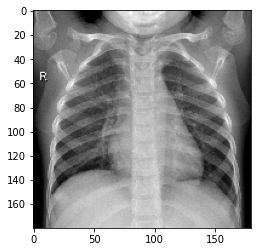

In [6]:
plt.imshow(x_train[0,:,:,0],cmap='gray')

In [7]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)

test_images = test_images.map(decode_img, num_parallel_calls=AUTOTUNE)

# SACO 5000 imagenes
BATCH_SIZE = 5000
ds = test_images.shuffle(10000)
test_ds = test_images.take(BATCH_SIZE)

test_ds = test_ds.batch(BATCH_SIZE)
x_test = next(iter(test_ds))

x_test = x_test.numpy()
x_test = x_test[:,:,:,0:1]
x_test.shape


(624, 180, 180, 1)

In [8]:
x_train.shape

(5000, 180, 180, 1)

In [9]:
# NOISE MASK

CENTRO = (90,94)
x_train_mod = x_train.copy()

noise_mask = np.random.randn(x_train_mod.shape[0],4,4)
noise_mask = noise_mask<0.9

noise_mask = np.tile(np.reshape(noise_mask,(*noise_mask.shape,1)),(1,1,1,1))


x_train_mod[:,CENTRO[0]:CENTRO[1],CENTRO[0]:CENTRO[1],:] = x_train_mod[:,CENTRO[0]:CENTRO[1],CENTRO[0]:CENTRO[1],:]*noise_mask

In [10]:
x_train_mod.shape

(5000, 180, 180, 1)

# MODELO

In [11]:


# ENCODER
input_img = Input(shape=x_train.shape[1:])  
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# DECODER
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


In [12]:
opt = Adam(learning_rate=0.0001)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=opt, loss='mse')

In [13]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       147584

In [ ]:
# ENTRENAMIENTO
hist = autoencoder.fit(x_train_mod, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_split=0.1)

Epoch 1/25
36/36 [==============================] - 57s 1s/step - loss: 0.0490 - val_loss: 0.0352
Epoch 2/25
36/36 [==============================] - 32s 897ms/step - loss: 0.0164 - val_loss: 0.0064
Epoch 3/25
36/36 [==============================] - 32s 896ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 4/25
36/36 [==============================] - 32s 893ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 5/25
36/36 [==============================] - 32s 895ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 6/25
36/36 [==============================] - 32s 895ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 7/25
36/36 [==============================] - 32s 894ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/25
36/36 [==============================] - 32s 895ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/25
36/36 [==============================] - 32s 896ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/25
36/36 [==============================] - 32s 894ms/step - loss: 0.0018 - val_loss:

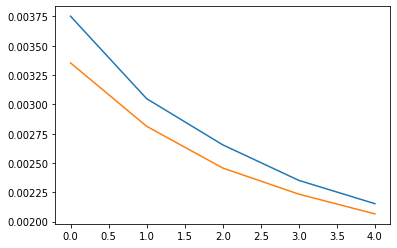

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

# Resultados reconstruyendo TODOS LOS PIXELS sin ruido

In [ ]:
# TEST
decoded_imgs = autoencoder.predict(x_test)

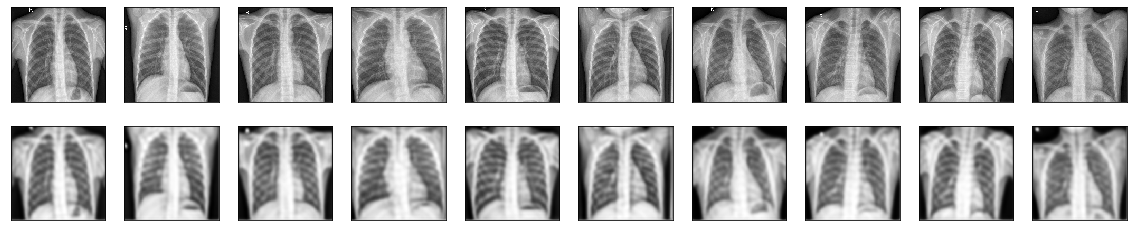

In [ ]:


n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(x_train.shape[1:-1]),interpolation='none')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruccion
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(x_train.shape[1:-1]),interpolation='none')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Resultados en test (metiendo ruido) tamaño fijo: cuadrado 4x4

In [ ]:
# TEST
x_test_mod = x_test.copy()
x_test_mod[:,CENTRO[0]:CENTRO[1],CENTRO[0]:CENTRO[1],:] = 0 
decoded_imgs = autoencoder.predict(x_test_mod)

reconstructed_imgs = x_test_mod.copy()
reconstructed_imgs[:,CENTRO[0]:CENTRO[1],CENTRO[0]:CENTRO[1],:] = decoded_imgs.reshape(x_test.shape)[:,CENTRO[0]:CENTRO[1],CENTRO[0]:CENTRO[1],:]

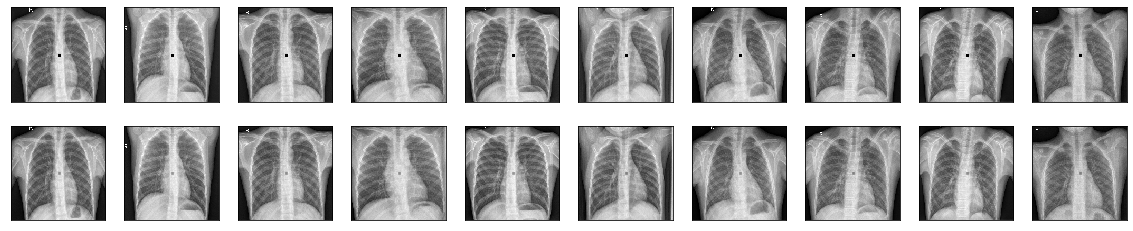

In [ ]:
import matplotlib.pyplot as plt

n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_mod[i].reshape(x_train.shape[1:-1]),interpolation='none')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruccion only in the desired pixels
    ax = plt.subplot(2, n, i + 1 + n)
    aux = reconstructed_imgs[i].reshape(x_train.shape[1:-1])
    plt.imshow(aux,interpolation='none')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

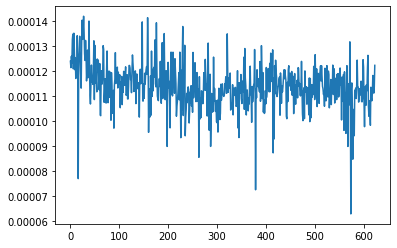

In [ ]:
E_rec = np.mean(np.abs(x_test-reconstructed_imgs),axis=(1,2,3))
plt.plot(E_rec)

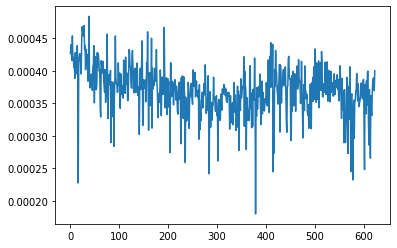

In [ ]:
E_ori = np.mean(np.abs(x_test-x_test_mod),axis=(1,2,3))
plt.plot(E_ori)

Text(0.5, 1.0, 'puntos por encima de la linea corresponden con una reconstrucción buena')

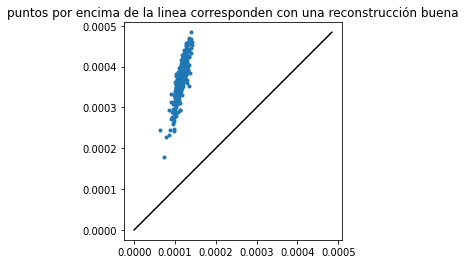

In [ ]:

plt.plot(E_rec,E_ori,'.')

plt.plot([0,max(E_ori)],[0,max(E_ori)],'k-')
plt.axis('square')
plt.title('puntos por encima de la linea corresponden con una reconstrucción buena')

In [ ]:
print(np.mean(E_rec)/np.mean(E_ori))

0.3075459


# Resultados en test (metiendo ruido) 
# patron variable: dentro de un cuadrado 4x4

In [ ]:
# NOISE MASK
x_test_mod = x_test.copy()

noise_mask = np.random.randn(x_test_mod.shape[0],4,4)
noise_mask = noise_mask<0.9

noise_mask = np.tile(np.reshape(noise_mask,(*noise_mask.shape,1)),(1,1,1,1))

In [ ]:
# TEST

x_test_mod[:,CENTRO[0]:CENTRO[1],CENTRO[0]:CENTRO[1],:] = x_test_mod[:,CENTRO[0]:CENTRO[1],CENTRO[0]:CENTRO[1],:]*noise_mask


In [ ]:

decoded_imgs = autoencoder.predict(x_test_mod)


In [ ]:
reconstructed_imgs = x_test_mod.copy()
reconstructed_imgs[:,CENTRO[0]:CENTRO[1],CENTRO[0]:CENTRO[1],:] = reconstructed_imgs[:,CENTRO[0]:CENTRO[1],CENTRO[0]:CENTRO[1],:] + decoded_imgs[:,CENTRO[0]:CENTRO[1],CENTRO[0]:CENTRO[1],:]*(1-noise_mask)

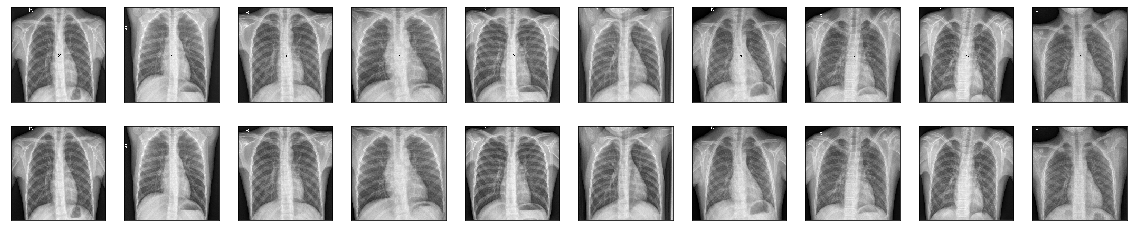

In [ ]:
import matplotlib.pyplot as plt

n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_mod[i].reshape(x_train.shape[1:-1]),interpolation='none')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruccion only in the desired pixels
    ax = plt.subplot(2, n, i + 1 + n)
    aux = reconstructed_imgs[i].reshape(x_train.shape[1:-1])
    plt.imshow(aux,interpolation='none')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.savefig('foo.png')
plt.show()

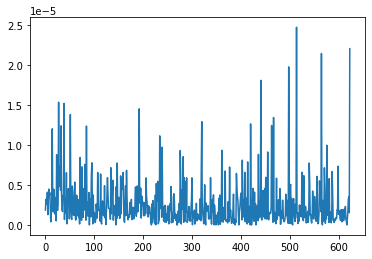

In [ ]:
E_rec = np.mean(np.abs(x_test-reconstructed_imgs),axis=(1,2,3))
plt.plot(E_rec)

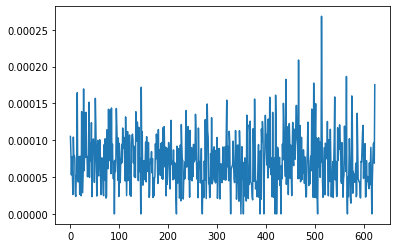

In [ ]:
E_ori = np.mean(np.abs(x_test-x_test_mod),axis=(1,2,3))
plt.plot(E_ori)

Text(0.5, 1.0, 'puntos por encima de la linea corresponden con una reconstrucción buena')

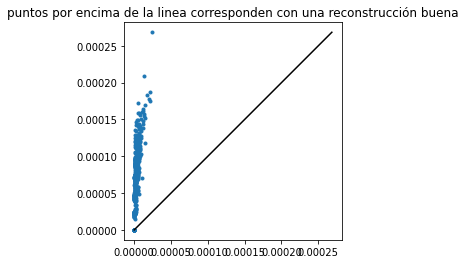

In [ ]:

plt.plot(E_rec,E_ori,'.')

plt.plot([0,max(E_ori)],[0,max(E_ori)],'k-')
plt.axis('square')
plt.title('puntos por encima de la linea corresponden con una reconstrucción buena')

In [ ]:
print(np.mean(E_rec)/np.mean(E_ori))

0.03589675
